In [2424]:
import pandas as pd
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#import pytorch_lightning as pl
from torch.autograd import Variable
import logging

from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
DATA_TYPE = torch.double
torch.set_default_dtype(DATA_TYPE)
device

device(type='cuda')

In [2425]:
def plot_model(x, y, examples, labels, model):
    # Generate 3D input points
    x1 = x
    x2 = y
    x1, x2 = torch.meshgrid(x1, x2)
    inputs = torch.stack([x1, x2], dim=2).view(-1, 2)

    # Pass the inputs through the model
    with torch.no_grad():
        outputs = model(inputs).view(x1.shape)
        outputs = outputs.cpu()
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(x1.cpu().numpy(), x2.cpu().numpy(), outputs.numpy(), cmap='viridis', alpha=0.7, color='blue')

    # Plot the input points
    ax.scatter(examples[:, 0], examples[:, 1], labels, color='red', s=10, label='Input Points')

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Output')
    ax.set_title('3D Plot of PyTorch Model Output')

    plt.show()

# Constants

In [2426]:

LEARNING_RATE = 0.1
NUM_EPOCHS = 150

# Data

In [2427]:
df_train = pd.read_csv('SDES_TRAIN.csv')
df_test = pd.read_csv('SDES_TEST.csv')
BATCH_SIZE = 10000

# Scaling

In [2428]:
m_scaler = MinMaxScaler()
s_scaler = StandardScaler()

df_train = pd.DataFrame(s_scaler.fit_transform(df_train), columns=df_train.columns)
df_train = pd.DataFrame(m_scaler.fit_transform(df_train), columns=df_train.columns)

df_train = df_train[:100]

# Data Load

In [2429]:
def embed(df):
    key = df['Key']
    msg = df['Message']
    cipher = df['Ciphertext']
    
    label = torch.tensor(key, dtype=DATA_TYPE)
    input = [torch.tensor([x, y], dtype=DATA_TYPE) for x, y in zip(msg, cipher)]
    input = torch.stack(input)
    dataset = TensorDataset(input, label)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0)
    return loader

train_loader = embed(df_train)

# Model Architecture

In [2430]:
class SDESModel(nn.Module):
    def __init__(self, size=0):
        super().__init__()
        
        # transform = nn.Sigmoid()
        
        # layers = [
        #     nn.Linear(2, 5),
        #     transform,
        #     nn.Linear(5, 10),
        #     transform,
        #     nn.Linear(10, 20),
        #     transform,
        #     nn.Linear(20, 30),
        #     transform,
        #     nn.Linear(30, 30),
        #     transform,
        #     nn.Linear(30, 40),
        #     transform,
        # ]
        
        # for _ in range(size):
        #     layers.append(nn.Linear(40, 40))
        #     layers.append(transform)
            
        # layers += [   
        #     nn.Linear(40, 30),
        #     transform,
        #     nn.Linear(30, 20),
        #     transform,
        #     nn.Linear(20, 10),
        #     transform,
        #     nn.Linear(10, 5),
        #     transform,
        #     nn.Linear(5, 1),
        #     transform,
        # ]
        
        # for layer in layers:
        #     if isinstance(layer, nn.Linear):
        #         nn.init.normal_(layer.weight, mean=0.5, std=0.5)
        #         nn.init.normal_(layer.bias, mean=0.5, std=0.5)
        #         #nn.init.sparse_(layer.bias, sparsity=0.5, std=0.1)
        # self.model = nn.Sequential(*layers)
        # self.network = nn.Sequential(
        #     nn.Linear(2, 5),
        #     nn.Linear(5, 10),
        #     nn.Linear(10, 10),
        #     nn.Linear(10, 5),
        #     nn.Linear(5, 1)
        # )
        self.network = nn.Sequential(
            nn.Linear(2, 1)
        )
    def forward(self, x):
        return self.network(x)

# Model Init

In [2431]:
model = SDESModel(0).to(device)

# Training Configurations

In [2432]:
LEARNING_RATE = 0.01
optimizer = optim.SGD(params=model.parameters(), lr=LEARNING_RATE)
NUM_EPOCHS = 100
BATCH_SIZE = len(df_train)

class CustomLoss(nn.Module):
    def __init__(self, alpha=1):
        super().__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()
        
    def forward(self, x, target):
        mse_loss = self.mse_loss(x, target)
        std = torch.var(x) + 0.1
        reg = self.alpha / std
        
        return mse_loss * reg
    
#criterion = CustomLoss(alpha=10)
criterion = nn.MSELoss()

# Training

In [2433]:
model.train()
torch.cuda.empty_cache()
for epoch in range(NUM_EPOCHS):
    for i, (x, target) in enumerate(train_loader):

        x, target = x.to(device), target.to(device)
        out = model(x)
        #print(out)
        
        optimizer.zero_grad()
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        del out
        torch.cuda.empty_cache()
        
        if i % 50 == 0:
            print(f'EPOCH {epoch}, batch {i}, loss {loss.item()}')
    print(f'EPOCH {epoch} finished')

C:\Users\Cristi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\_device.py:77: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


EPOCH 0, batch 0, loss 0.18996974223584812
EPOCH 0 finished
EPOCH 1, batch 0, loss 0.18520007455464307
EPOCH 1 finished
EPOCH 2, batch 0, loss 0.18070636481960262
EPOCH 2 finished
EPOCH 3, batch 0, loss 0.17647241905081132
EPOCH 3 finished
EPOCH 4, batch 0, loss 0.1724829941877473
EPOCH 4 finished
EPOCH 5, batch 0, loss 0.16872374224914957
EPOCH 5 finished
EPOCH 6, batch 0, loss 0.16518115777194822
EPOCH 6 finished
EPOCH 7, batch 0, loss 0.16184252833670337
EPOCH 7 finished
EPOCH 8, batch 0, loss 0.1586958879983059
EPOCH 8 finished
EPOCH 9, batch 0, loss 0.15572997345133552
EPOCH 9 finished
EPOCH 10, batch 0, loss 0.15293418276949217
EPOCH 10 finished
EPOCH 11, batch 0, loss 0.15029853656794373
EPOCH 11 finished
EPOCH 12, batch 0, loss 0.14781364144631115
EPOCH 12 finished
EPOCH 13, batch 0, loss 0.14547065557836722
EPOCH 13 finished
EPOCH 14, batch 0, loss 0.14326125632238806
EPOCH 14 finished
EPOCH 15, batch 0, loss 0.14117760973350063
EPOCH 15 finished
EPOCH 16, batch 0, loss 0.1392

In [2434]:
input = [torch.tensor([x, y], dtype=DATA_TYPE) for x, y in zip(df_train['Message'], df_train['Ciphertext'])]
input = torch.stack(input)
keys = torch.tensor(df_train['Key'], dtype=DATA_TYPE).cpu()
input

tensor([[0.3686, 0.5216],
        [0.4392, 0.9137],
        [0.7373, 0.6275],
        [0.0431, 0.9059],
        [0.5333, 0.0784],
        [0.7843, 0.8000],
        [0.8510, 0.6941],
        [0.6196, 0.7098],
        [0.8588, 0.2392],
        [0.1059, 0.6392],
        [0.2784, 0.9686],
        [0.3529, 0.0000],
        [0.7137, 0.1020],
        [0.8941, 0.6902],
        [0.3216, 0.0588],
        [0.7333, 0.3137],
        [0.1255, 0.0941],
        [0.5882, 0.7059],
        [0.6353, 0.1137],
        [0.3176, 0.6980],
        [0.9529, 0.5569],
        [0.3882, 0.2157],
        [0.3725, 0.6510],
        [0.2039, 0.8235],
        [0.9765, 0.0196],
        [0.7294, 0.4078],
        [0.1216, 0.1529],
        [0.9804, 0.6039],
        [0.8980, 0.5608],
        [0.5294, 0.8627],
        [0.5098, 0.5451],
        [0.4039, 0.6824],
        [0.0471, 0.8745],
        [0.6627, 0.6588],
        [0.1686, 0.7176],
        [0.4314, 0.6824],
        [0.8863, 0.9882],
        [0.6980, 0.3373],
        [0.3

In [2435]:
model.eval()
outputs = model(input)
outputs = outputs.cpu().detach()

df_out = pd.DataFrame(df_train)
df_out['Key'] = outputs.numpy()
df_out = pd.DataFrame(m_scaler.inverse_transform(df_out), columns=df_out.columns)
df_out = pd.DataFrame(s_scaler.inverse_transform(df_out), columns=df_out.columns)

df_out

,Message,Ciphertext,Key
0,9.400000e+01,133.0,493.134950
1,1.120000e+02,233.0,671.977031
2,1.880000e+02,160.0,632.614944
3,1.100000e+01,231.0,565.442747
4,1.360000e+02,20.0,354.818905
...,...,...,...
95,8.800000e+01,144.0,504.643823
96,-1.421085e-14,83.0,316.756610
97,2.400000e+01,32.0,259.491186
98,1.560000e+02,37.0,402.552137


In [2436]:
df_train = pd.DataFrame(m_scaler.inverse_transform(df_train), columns=df_train.columns)
df_train = pd.DataFrame(s_scaler.inverse_transform(df_train), columns=df_train.columns)

df_train

,Message,Ciphertext,Key
0,9.400000e+01,133.0,30.0
1,1.120000e+02,233.0,819.0
2,1.880000e+02,160.0,70.0
3,1.100000e+01,231.0,79.0
4,1.360000e+02,20.0,37.0
...,...,...,...
95,8.800000e+01,144.0,195.0
96,-1.421085e-14,83.0,446.0
97,2.400000e+01,32.0,522.0
98,1.560000e+02,37.0,824.0


In [2437]:
torch.mean(keys)

tensor(0.4980)

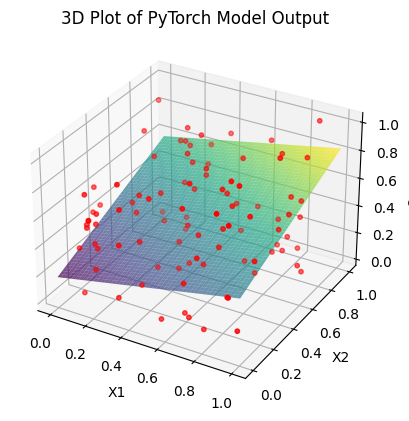

In [2438]:
precision = 50
x = torch.linspace(0, 1, precision)
y = torch.linspace(0, 1, precision)

plot_model(x, y, input.cpu(), keys, model)